In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM_AGM)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv
from src.features.add_features import features_graph, features_pop

In [2]:
import xgboost as xgb
import pandas as pd
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, expon, randint, loguniform

In [3]:
df_1 = pd.read_pickle('../data/processed/sim_closure_100k.pickle')
df_2 = pd.read_pickle('../data/processed/sim_closure_topk_10k.pickle')
df_3 = pd.read_pickle('../data/processed/sim_closure_errors_50k.pickle')
df = pd.concat([df_1, df_2, df_3])
df.reset_index(inplace=True, drop=True)
df

,initial_country,idx_country,R0,Tc,Tr,omega,limit_deaths,n_closed,react_time,total_infected,total_death,total_recovered
0,LBN,106,8.490802,2.474947,21.014286,0.059029,72,6,23,5.784074e+09,3.219167e+09,2.595155e+09
1,KIR,99,2.161672,8.939155,19.323523,0.002080,872,2,2,4.535617e+09,1.748364e+08,4.350775e+09
2,MOZ,129,15.439975,1.345278,20.771054,0.036275,192,0,22,5.557288e+09,2.399471e+09,3.184538e+09
3,ERI,58,1.141326,2.156481,2.461249,0.004779,511,9,28,8.534615e+08,9.893725e+06,8.421974e+08
4,VCT,174,8.327237,1.335545,11.121400,0.048201,958,18,20,3.785881e+09,1.321729e+09,2.465612e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
159995,DNK,50,4.620380,7.233849,33.423136,0.102459,582,2,11,1.328000e+03,9.180000e+02,1.390000e+02
159996,EGY,55,7.207862,4.106823,29.601418,0.016480,916,8,22,9.820544e+07,3.220008e+07,6.600511e+07
159997,BEL,17,6.243168,2.990577,18.670672,0.217828,876,2,29,8.913369e+06,7.154230e+06,1.758950e+06
159998,FRA,65,1.307888,14.478813,18.936663,0.007714,964,13,21,3.713000e+03,2.630000e+02,2.781000e+03


In [4]:
df = features_graph(df)
df = features_pop(df)

In [5]:
# df_model = df[['R0', 'Tr', 'omega', 'limit_deaths', 'n_closed', 'react_time', 'total_death', 'betweenness', 'degree', 'closeness',
#                'country_pop']]

df_model = df[['R0', 'Tr', 'omega', 'total_death', 'betweenness', 'degree',
               'country_pop']]


df_model

,R0,Tr,omega,total_death,betweenness,degree,country_pop
0,8.490802,21.014286,0.059029,3.219167e+09,0.001057,0.270270,6848925.0
1,2.161672,19.323523,0.002080,1.748364e+08,0.000956,0.036036,115847.0
2,15.439975,20.771054,0.036275,2.399471e+09,0.000059,0.054054,29495962.0
3,1.141326,2.461249,0.004779,9.893725e+06,0.000007,0.049550,3213972.0
4,8.327237,11.121400,0.048201,1.321729e+09,0.000035,0.040541,110210.0
...,...,...,...,...,...,...,...
159995,4.620380,33.423136,0.102459,9.180000e+02,0.012772,0.414414,5797446.0
159996,7.207862,29.601418,0.016480,3.220008e+07,0.008501,0.405405,98423595.0
159997,6.243168,18.670672,0.217828,7.154230e+06,0.015355,0.522523,11422068.0
159998,1.307888,18.936663,0.007714,2.630000e+02,0.125422,0.995495,66987244.0


In [6]:
X = df_model.drop('total_death', axis=1)
y = df_model['total_death']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train_val = pd.concat([X_train_val, y_train_val], axis=1)

In [7]:
subset = int(df_train_val.shape[0] * 0.5)
df_train_val = df_train_val.sample(subset) # con cuantas muestras quiero entrenar

X_train_val = df_train_val.drop('total_death', axis=1)
y_train_val = df_train_val['total_death']

print(f"Test size: {X_test.shape}")
print(f"Training size: {X_train_val.shape}")

Test size: (32000, 6)
Training size: (64000, 6)


In [8]:
param_dist = dict(
    max_depth=randint(low=1, high=11),
    learning_rate=loguniform(0.01, 0.1),
    subsample=uniform(loc=0.8, scale=1-0.8),
    colsample_bytree=uniform(loc=0.8, scale=1-0.8),
    gamma=[0, 1, 5]
)

# model = xgb.XGBRegressor(scale_pos_weight=1,
#                          learning_rate=0.01,
#                          colsample_bytree=0.4,
#                          subsample=0.8,
#                          n_estimators=100,
#                          reg_alpha=0.3,
#                          max_depth=4,
#                          gamma=10)

grid = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_dist, verbose=2,
                          n_iter=50, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

grid.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.2min finished


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7feb29eea280>,
                                        'gamma': [0, 1, 5],
                  

In [9]:
results_searchcv(grid, X_test, y_test)

The best score is:
-1270032960893042.0
The best parameters found are:
{'colsample_bytree': 0.9853317731587589, 'gamma': 5, 'learning_rate': 0.08353610755311759, 'max_depth': 8, 'subsample': 0.9140887948810799}
The score in test is:
-1579088365459651.0
The r2-square is
0.8908503750442599
The MAE is:
5078027.432966247


In [10]:
X_err = X_test.copy()
X_err['predicted'] = grid.predict(X_test)
X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err

,R0,Tr,omega,betweenness,degree,country_pop,predicted,real,error,abs_error
120476,5.030523,33.705703,0.076330,0.009627,0.387387,33699947.0,1.665821e+07,20281253.0,3.623043e+06,3.623043e+06
32693,19.650069,7.994974,0.307265,0.001597,0.054054,18008.0,1.499528e+06,12782.0,-1.486746e+06,1.486746e+06
79958,10.544825,3.066854,0.018615,0.000050,0.063063,96762.0,-2.633413e+05,5211.0,2.685523e+05,2.685523e+05
76366,2.392115,5.893584,0.001291,0.000064,0.063063,3170208.0,1.128750e+05,21179.0,-9.169598e+04,9.169598e+04
82343,6.980829,20.991835,0.211865,0.002179,0.378378,10727668.0,7.223307e+06,7326304.0,1.029970e+05,1.029970e+05
...,...,...,...,...,...,...,...,...,...,...
87335,11.783842,16.244929,0.307751,0.003000,0.036036,58791.0,1.206412e+05,48369.0,-7.227220e+04,7.227220e+04
127213,10.825835,15.235878,0.006571,0.012772,0.414414,5797446.0,7.779019e+05,527501.0,-2.504009e+05,2.504009e+05
11241,6.326920,21.341923,0.004674,0.003337,0.180180,267663435.0,2.329735e+07,24237419.0,9.400690e+05,9.400690e+05
131826,10.050913,28.745151,0.073899,0.009627,0.387387,33699947.0,2.260714e+07,22834196.0,2.270580e+05,2.270580e+05


In [11]:
X.describe()

,R0,Tr,omega,betweenness,degree,country_pop
count,160000.000000,160000.000000,1.600000e+05,160000.000000,160000.000000,1.600000e+05
mean,9.441980,16.058520,9.968302e-02,0.018584,0.349921,8.748807e+07
std,5.576188,8.344035,9.961719e-02,0.032519,0.273589,2.591787e+08
min,1.000032,2.000186,8.708836e-07,0.000000,0.009009,1.164600e+04
25%,4.791136,9.286042,2.871102e-02,0.000296,0.094595,3.545883e+06
50%,8.621683,16.054953,6.922407e-02,0.005876,0.306306,1.500815e+07
75%,13.752562,21.065893,1.380303e-01,0.020834,0.545045,6.043128e+07
max,20.999739,34.999899,1.268734e+00,0.184702,0.995495,1.392730e+09


In [12]:
X_err.sort_values(by='abs_error', ascending=False).iloc[:100].describe()

,R0,Tr,omega,betweenness,degree,country_pop,predicted,real,error,abs_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
mean,6.957952,21.000135,0.169099,0.020150,0.450225,1.087114e+09,3.433135e+08,4.537963e+08,1.104828e+08,5.058899e+08
std,4.217243,8.468446,0.121293,0.010212,0.150871,5.564999e+08,2.205466e+08,5.731304e+08,6.672327e+08,4.461161e+08
min,1.850558,2.399120,0.008789,0.000000,0.036036,5.879100e+04,-4.418132e+05,0.000000e+00,-7.300646e+08,2.345985e+08
25%,4.177876,16.128863,0.083508,0.017188,0.441441,1.352617e+09,2.249076e+08,1.180525e+04,-3.797663e+08,2.865399e+08
50%,5.770705,21.624684,0.147393,0.017188,0.441441,1.352617e+09,3.762996e+08,2.973736e+08,2.389227e+08,3.779338e+08
75%,8.285308,27.185391,0.215175,0.030666,0.563063,1.392730e+09,4.999437e+08,8.011052e+08,3.713910e+08,5.143489e+08
max,20.484964,34.948918,0.823186,0.035806,0.725225,1.392730e+09,7.391345e+08,3.219167e+09,3.214740e+09,3.214740e+09


In [13]:
y_predicted = grid.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

In [14]:
df_predicted

,Actual,Predicted
120476,20281253.0,1.665821e+07
32693,12782.0,1.499528e+06
79958,5211.0,-2.633413e+05
76366,21179.0,1.128750e+05
82343,7326304.0,7.223307e+06
...,...,...
87335,48369.0,1.206412e+05
127213,527501.0,7.779019e+05
11241,24237419.0,2.329735e+07
131826,22834196.0,2.260714e+07


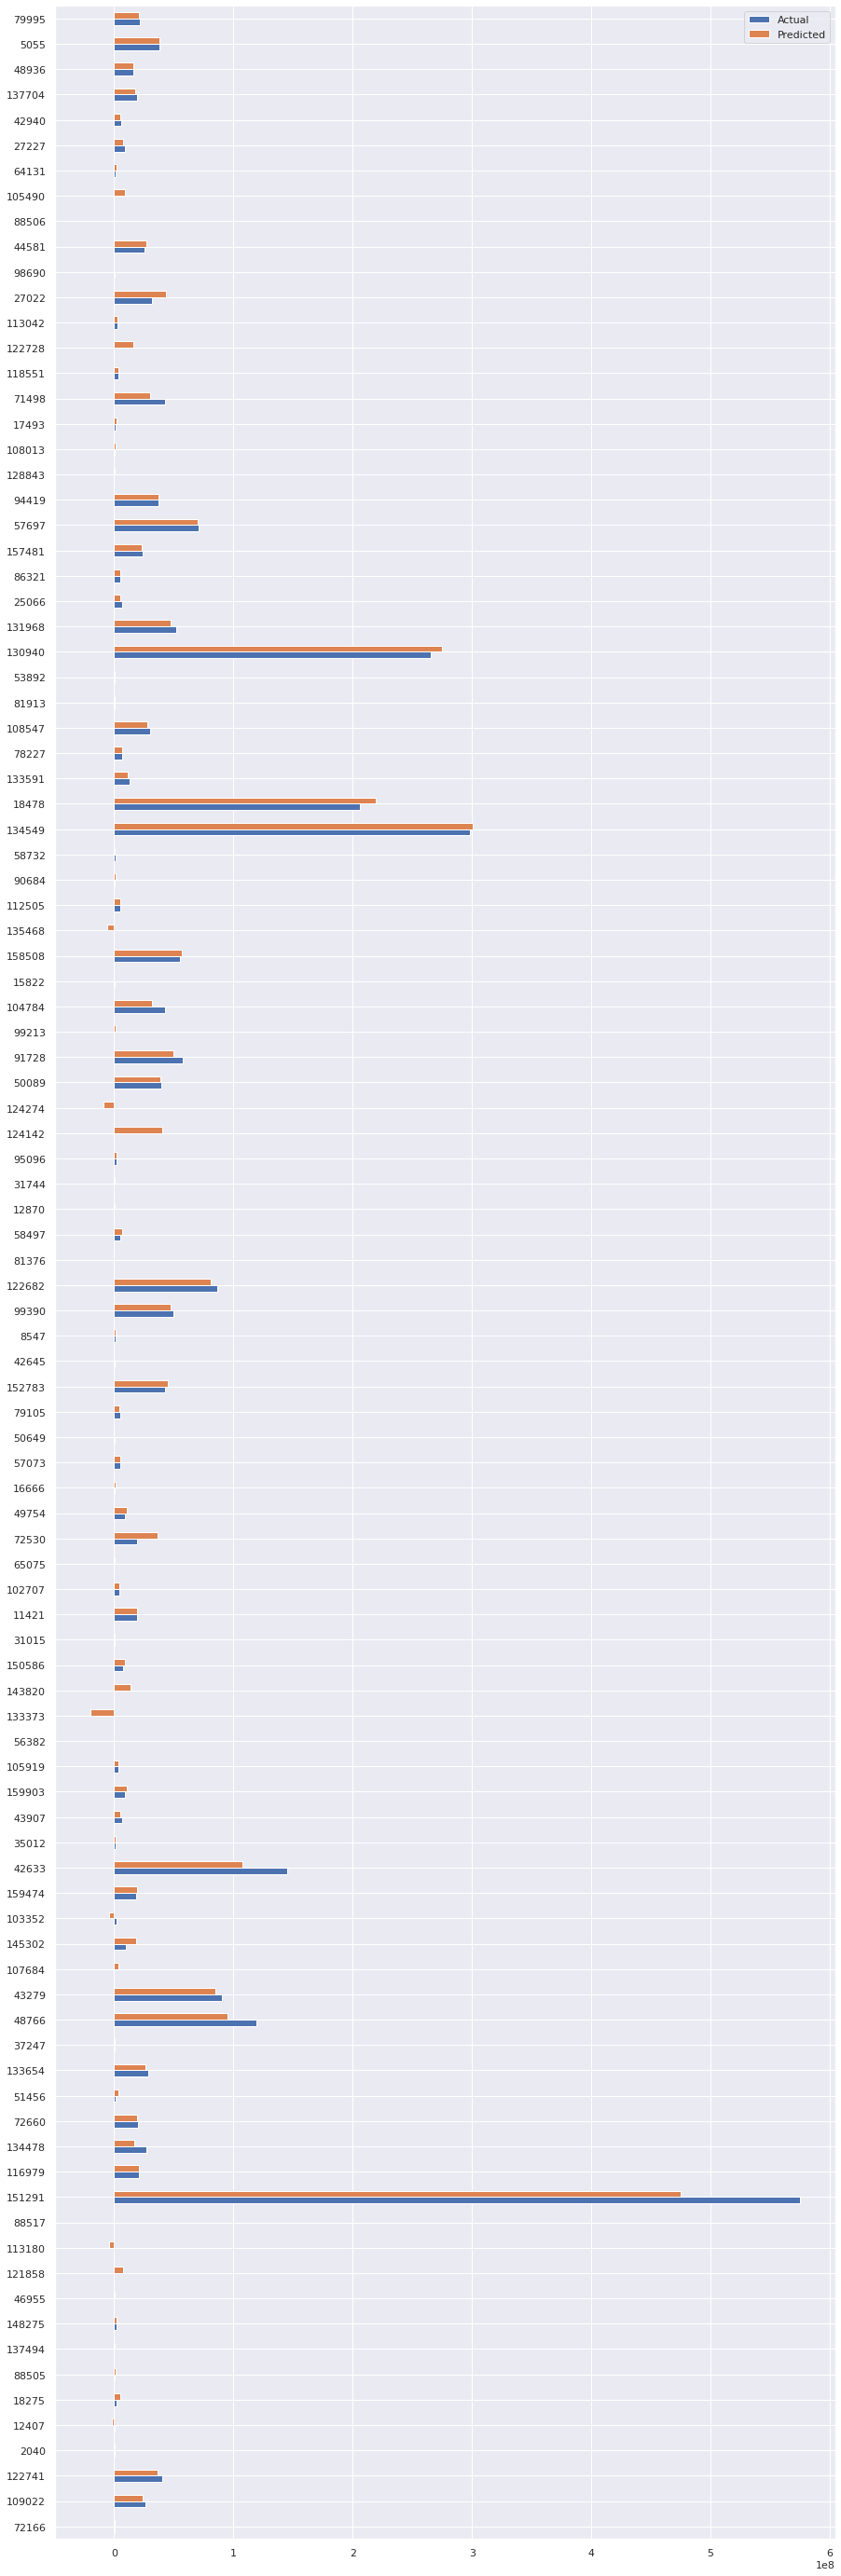

In [15]:
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()